In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

In [177]:
# On récupère et on prévisualise notre dataset (source : https://www.kaggle.com/datasets/mirichoi0218/insurance)

df = pd.read_csv('insurance.csv')
df.sample(3)

,age,sex,bmi,children,smoker,region,charges
874,44,male,21.85,3,no,northeast,8891.13950
1162,30,male,38.83,1,no,southeast,18963.17192
30,22,male,35.60,0,yes,southwest,35585.57600


In [178]:
# On vérifie s'il manque des valeurs dans certaines colonnes

(df.count()/df.shape[0]*100).astype(int).to_frame().rename({0 : 'Remplissage (%)'}, axis=1)

,Remplissage (%)
age,100
sex,100
bmi,100
children,100
smoker,100
region,100
charges,100


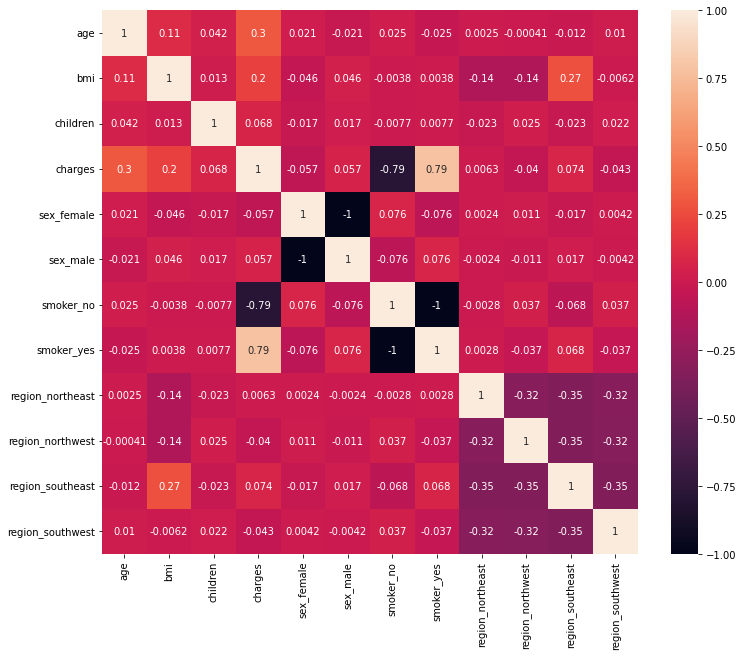

In [179]:
# On peut prévisualiser les corrélations entre colonnes à l'aide d'une heatmap

plt.figure(figsize=(12,10))
sns.heatmap(pd.get_dummies(df).corr(), annot=True)
plt.show()

In [180]:
# On défini les variables explicatives (X) et la variable expliquée (y)

X = df.drop(columns=['charges'])
y = df['charges']

In [181]:
# Vérifions le coefficient et la p_value de chaques features potentielles

X_dummies = pd.get_dummies(X)
linreg = LinearRegression().fit(X_dummies, y)
ols = sm.OLS(y, sm.add_constant(X_dummies)).fit()

coefs = pd.DataFrame({
    "coefficent": pd.Series(linreg.coef_, index = X_dummies.columns),
    "p_value (%)":  pd.Series(ols.pvalues*100, index = ols.pvalues.index[1:])})

coefs\
    .applymap(lambda x: int(x))\
    .style.applymap(lambda x: 'color: red' if x == 0 else 'color: black')

,coefficent,p_value (%)
age,256,0
bmi,339,0
children,475,0
sex_female,65,75
sex_male,-65,43
smoker_no,-11924,0
smoker_yes,11924,0
region_northeast,587,8
region_northwest,234,59
region_southeast,-448,11


In [182]:
# On peut drop les colonnes 'sex' et 'region' dont la p_value est supérieure à 0.05

X.drop(columns=['sex', 'region'], inplace=True)

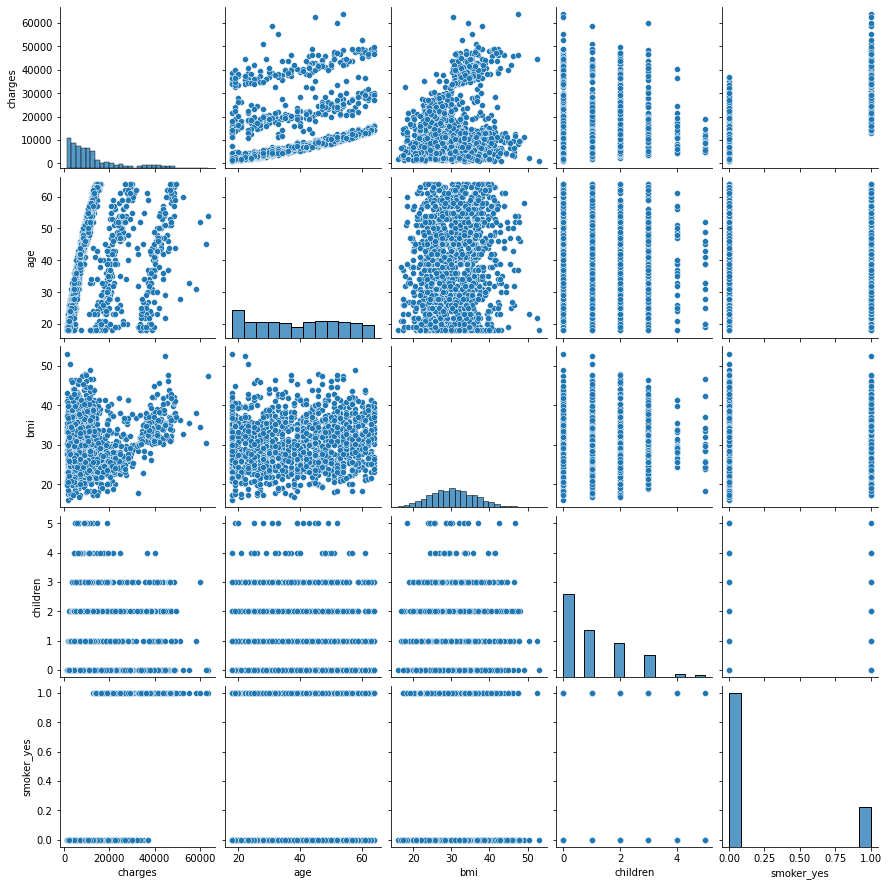

In [183]:
# On peut visualisez graphiquement les relations entre les différentes features à l'aide d'un pairplot

sns.pairplot(pd.concat([y, pd.get_dummies(X).drop(columns='smoker_no')], axis=1));

In [184]:
# On divise nos données en deux datasets : un d'entrainement et un de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [188]:
# On créé un pipeline

num_cols = X._get_numeric_data().columns.values.tolist()
cat_cols = list(set(X.columns)-set(X._get_numeric_data().columns))
        
num_pipeline = Pipeline([('scaler', MinMaxScaler())])
        
preprocessor = ColumnTransformer([
    ('num_transformer', num_pipeline, num_cols),
    ('cat_transformer', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)])
        
pipeline = make_pipeline(preprocessor, LinearRegression())
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['smoker'])])),
                ('linearregression', LinearRegression())])

In [186]:
# On créé notre modèle en fitant le pipeline sur X_train et y_train
        
model = pipeline.fit(X_train, y_train)

In [187]:
# On évalue notre modèle sur la partie d'entrainement (avec la cross validation) et la partie de test

print('Cross validation :')
for i, r2 in enumerate(cross_val_score(model, X_train, y_train, cv=5, scoring='r2')):
    (R2 := np.array(r2))
    print(f' {i+1}. r2 = {round(r2,2)}')
print('Moyenne des r2 :', round(R2.mean(),2))
print('\nScore du test :', round(model.score(X_test,y_test),2))

Cross validation :
 1. r2 = 0.8
 2. r2 = 0.71
 3. r2 = 0.68
 4. r2 = 0.79
 5. r2 = 0.76
Moyenne des r2 : 0.76

Score du test : 0.74


### On obtient un score correct entre $0.7$ et $0.8$.

### Pour l'améliorer, on pourrait essayer d'ajouter de nouvelles features à notre modèle. Pour ce faire, il faudrait récupérer plus de données pertinentes sur les patients ayant idéalement peu de colinéarités avec les features déjà sélectionnées.